In [1]:
import os , cv2 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify
from tensorflow import keras 
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler


In [2]:
DIR_PATH ="E:/data Science/Semantic segmentation dataset/"
scaler = MinMaxScaler()
patch_size = 256 
image_data = []

for path ,subdirs , files in os.walk(DIR_PATH):
  dirname= path.split(os.path.sep)[-1]
  if dirname =='images':
    images = os.listdir(path)
    for i , image_name in enumerate(images):
      image=cv2.imread(path + "/" + image_name , 1)
      width = (image.shape[1]//patch_size)*patch_size
      height = (image.shape[0]//patch_size)*patch_size

      image = Image.fromarray(image)
      image = image.crop((0,0,width,height))
      image = np.array(image)

      #extract the patches from the images
      #print('Now patchifying image:', path+"/"+image_name)
      patches = patchify(image , (patch_size , patch_size , 3) , step=patch_size)


      for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
          single_patch_image = patches[i,j,:,:]
          # single_patch_image = scaler.fit_transform(single_patch_image.reshape(-1, single_patch_image.shape[-1])).reshape(single_patch_image.shape)


          single_patch_image = scaler.fit_transform(single_patch_image.reshape(-1 , single_patch_image.shape[-1])).reshape(single_patch_image.shape)
          single_patch_image = single_patch_image[0]
          image_data.append(single_patch_image)


          



In [3]:
mask_data = []


for path , subdirs, files in os.walk(DIR_PATH):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        for i , mask_name in enumerate(masks):
            mask = cv2.imread(path+"/" + mask_name,1)
            mask = cv2.cvtColor(mask ,cv2.COLOR_BGR2RGB)
            width = (mask.shape[1]//patch_size)*patch_size
            height = (mask.shape[0]//patch_size)*patch_size

            mask = Image.fromarray(mask)  #convert the image into PIL  object 
            mask = mask.crop((0,0,width,height))
            mask = np.array(mask)

           #extract the pacthes from the mask 
            patches_mask = patchify(mask , (patch_size , patch_size , 3) , step=patch_size) #step=256 means  the stride of 256 therefore no overlapping
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):

                  single_patch_mask=patches_mask[i,j,:,:]
            #optional 
                #   single_patch_mask = scaler.fit_transform(single_patch_mask.reshape(-1, single_patch_mask[-1])).reshape(-1, single_patch_mask.shape)
            

                  single_patch_mask=single_patch_mask[0]   #hereby droppping the unimportant pixels
                  mask_data.append(single_patch_mask)




In [4]:
print(type(image_data))
print(len(image_data))
print(type(mask_data))
print(len(mask_data))


<class 'list'>
1305
<class 'list'>
1305


In [5]:
image_data = np.array(image_data)
mask_data = np.array(mask_data)

In [6]:
print(image_data.shape)
print(mask_data.shape)

(1305, 256, 256, 3)
(1305, 256, 256, 3)


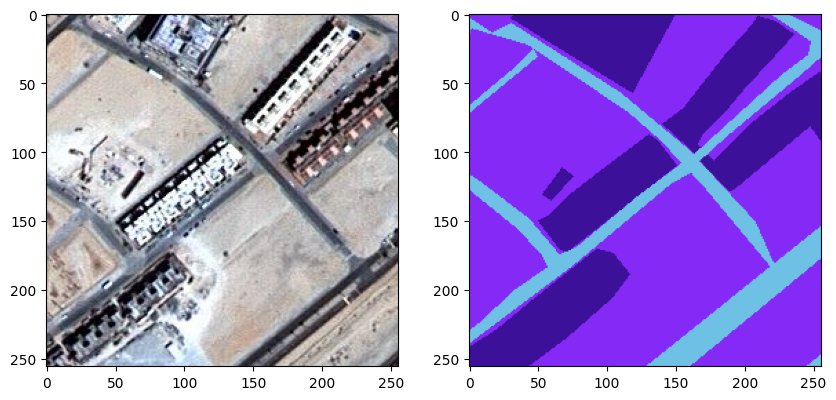

In [7]:
import random 
sample = random.randint(0,len(image_data))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image_data[sample])
plt.subplot(122)
plt.imshow(mask_data[sample])
plt.show()

In [8]:
dict = {"Building" : "#3C1098",
"Land" : "#8429F6",
"Road" : "#6EC1E4",
"Vegetation" : "#FEDD3A",
"Water" : "#E2A929",
"Unlabeled" : "#9B9B9B"}

In [9]:
#converting Hexadecimal to int

RGB_label={}
for key , value in  dict.items():
    value = value.lstrip('#')
    RGB = np.array(tuple(int(value[i:i+2] , 16) for i in (0,2,4)))
    RGB_label[key] = RGB

print(RGB_label)

{'Building': array([ 60,  16, 152]), 'Land': array([132,  41, 246]), 'Road': array([110, 193, 228]), 'Vegetation': array([254, 221,  58]), 'Water': array([226, 169,  41]), 'Unlabeled': array([155, 155, 155])}


In [10]:
def rgb_to_2d_label(label):
    label_array = np.zeros(label.shape , dtype=np.int8)

    for i , (key, value) in enumerate(RGB_label.items()):
        label_array[np.all(label == value , axis=-1)]=i
     

    label_array=label_array[: , : , 0] #it take on;y the first channel
    return label_array

In [11]:
labels = []
for i in range(mask_data.shape[0]):
    label = rgb_to_2d_label(mask_data[i])
    labels.append(label)

labels = np.array(labels)
   

In [12]:
labels.shape

(1305, 256, 256)

In [13]:
labels=np.expand_dims(labels , axis=3)
labels.shape

(1305, 256, 256, 1)

In [14]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=int8)

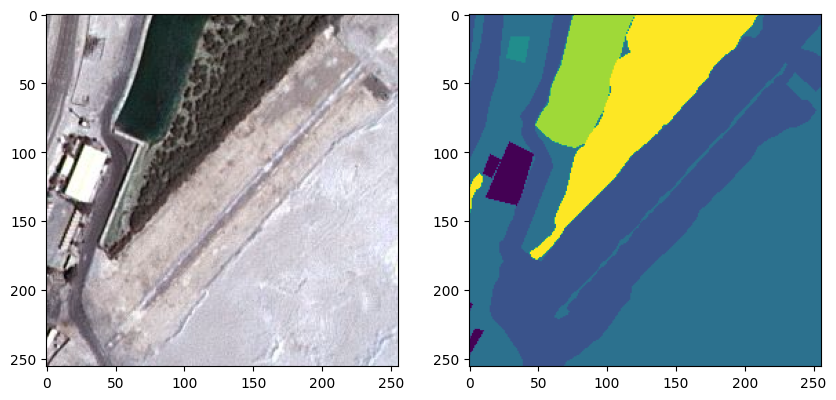

(256, 256, 1)


In [15]:
#  Check whether image and mask matches or not
sample = random.randint(0, len(labels))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image_data[sample])
plt.subplot(122)
plt.imshow(mask_data[sample][:,:,0])
plt.show()
print(labels[sample].shape)

In [16]:
import keras 

In [17]:
#one hot encoding on mask make seperate label for each class
from keras.utils import to_categorical
num_classes = len(np.unique(labels))
labels_cat= to_categorical(labels , num_classes = num_classes)


In [18]:
labels_cat.shape

(1305, 256, 256, 6)

In [19]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(image_data , labels_cat , test_size=0.2 , random_state=42)
x_train.shape , x_test.shape , y_train.shape , y_test.shape

((1044, 256, 256, 3),
 (261, 256, 256, 3),
 (1044, 256, 256, 6),
 (261, 256, 256, 6))

In [20]:
from keras.models import Model 
from keras.layers import Input , Conv2D , MaxPooling2D , UpSampling2D , concatenate , Conv2DTranspose , BatchNormalization
from keras.optimizers import Adam
from keras.layers import Activation , MaxPool2D , Concatenate

In [21]:
from tensorflow import keras
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
#from keras.layers.convolutional import Conv2D
from keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)     # Not in original unet network
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)     # Not in original unet network
    x = Activation('relu')(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2,2))(x)

    return x, p

def decoder_block(input, skip_feature, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_feature])
    x = conv_block(x, num_filters)

    return x


def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)       #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(num_classes, 1, padding="same", activation ="softmax")(d4)

    model = Model(inputs, outputs, name="u_net")

    return model

In [22]:
# from u_net_model.ipynb import build_unet

IMAGE_HEIGHT= 256
IMAGE_WIDTH= 256
IMAGE_CHANNELS= 3

input_shape = (IMAGE_HEIGHT , IMAGE_WIDTH , IMAGE_CHANNELS)
num_classes = 6
model = build_unet(input_shape = input_shape , num_classes = num_classes)
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy" , metrics = "accuracy")
model.summary()

Model: "u_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [23]:
# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("semantic_segmentation_aerial_satelite_images.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, mode='min')

history = model.fit(x_train, y_train, batch_size=1, epochs=25, validation_data=(x_test, y_test),
                    callbacks=[checkpoint_cb, early_stopping_cb], shuffle=False)

Epoch 1/25
1044/1044 [==============================] - 1430s 1s/step - loss: 1.0274 - accuracy: 0.6425 - val_loss: 0.9147 - val_accuracy: 0.6778
Epoch 2/25
1044/1044 [==============================] - 1347s 1s/step - loss: 0.8201 - accuracy: 0.7231 - val_loss: 0.8482 - val_accuracy: 0.6962
Epoch 3/25
1044/1044 [==============================] - 1467s 1s/step - loss: 0.7300 - accuracy: 0.7547 - val_loss: 0.8832 - val_accuracy: 0.6731
Epoch 4/25
1044/1044 [==============================] - 1374s 1s/step - loss: 0.6792 - accuracy: 0.7705 - val_loss: 0.8756 - val_accuracy: 0.6787


In [24]:
model.save("semantic_segmentation_aerial_satelite_images_1.h5")

In [25]:
# save the test data for prediction
import pickle

pickle_out = open("x_test.pickle", "wb")
pickle.dump(x_test, pickle_out)
pickle_out.close()

pickle_out = open("y_test.pickle", "wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()